# 🖥️ Tech Twitter Dataset Analysis

This notebook analyzes the **Tech Twitter dataset (1.7GB)** with a **hybrid approach** combining chunked processing for large data with DataFrame-based analysis for consistency.

## 📊 **Hybrid Processing Strategy:**
- **Chunked data loading** for memory safety with 1.7GB dataset
- **DataFrame conversion** after chunked processing for analysis consistency
- **Structural alignment** with Climate and COVID analysis notebooks
- **Progressive processing** with checkpoint/resume capabilities

## ⚡ **Features:**
- **Memory-safe gradual processing** with aggressive memory management
- **DataFrame-based analysis** matching climate/COVID structure
- **Configurable chunk sizes** and processing batches  
- **Progressive analysis** with intermediate results
- **Memory monitoring** and automatic cleanup
- **Resumable processing** with checkpoint saving
- **Consistent export format** for LLM training data

## 🎯 **Active Users Focus:**
- Identify users with **6+ tweets** for LLM agent training
- Network behavior analysis and engagement patterns
- Tech-specific hashtag and topic analysis
- Export functionality compatible with other datasets

In [7]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from datetime import datetime
import gc
import psutil
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("viridis")

def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

def print_memory_status():
    """Print current memory status"""
    memory_mb = get_memory_usage()
    print(f"💾 Current memory usage: {memory_mb:.1f} MB")
    if memory_mb > 12000:  # Warning at 12GB
        print("⚠️  High memory usage detected!")

print("🖥️ TECH DATASET ANALYSIS NOTEBOOK")
print("=" * 50)
print(f"Available RAM: {psutil.virtual_memory().available / (1024**3):.2f} GB")
print(f"Total RAM: {psutil.virtual_memory().total / (1024**3):.2f} GB")
print_memory_status()

🖥️ TECH DATASET ANALYSIS NOTEBOOK
Available RAM: 9.25 GB
Total RAM: 15.51 GB
💾 Current memory usage: 175.1 MB


In [8]:
class TechTwitterAnalyzer:
    """Tech Twitter dataset analyzer with hybrid chunked+DataFrame processing for large datasets"""
    
    def __init__(self, jsonl_file_path='tech_tweets2.jsonl', checkpoint_file='tech_analysis_checkpoint.pkl'):
        self.jsonl_file = jsonl_file_path
        self.checkpoint_file = checkpoint_file
        
        # Chunked processing storage
        self.user_stats = defaultdict(lambda: {
            'tweet_count': 0,
            'tweets': [],
            'hashtags': [],
            'mentions': [],
            'retweets': 0,
            'replies': 0,
            'timestamps': []
        })
        
        # DataFrame storage (for consistency with climate/COVID)
        self.tweets_df = None
        self.users_df = None
        
        # Processing state
        self.total_tweets = 0
        self.processed_tweets = 0
        self.processing_complete = False
        self.last_processed_line = 0
        
        # Memory management settings
        self.memory_threshold = 85  # Stop processing if RAM usage exceeds this %
        self.aggressive_cleanup = True
        
        print(f"🖥️ Initializing Tech Twitter Analyzer")
        print(f"📁 Data file: {self.jsonl_file}")
        print(f"💾 Checkpoint file: {self.checkpoint_file}")
    
    def monitor_memory(self, step_name="", force_cleanup=False):
        """Monitor current memory usage with optional cleanup"""
        if force_cleanup:
            gc.collect()
        
        memory = psutil.virtual_memory()
        print(f"{step_name} - RAM: {memory.percent:.1f}% ({memory.available/(1024**3):.2f}GB available)")
        
        if memory.percent > self.memory_threshold:
            print(f"⚠️  WARNING: Memory usage ({memory.percent:.1f}%) exceeds threshold ({self.memory_threshold}%)")
            if self.aggressive_cleanup:
                self.cleanup_memory()
        
        return memory.percent
    
    def cleanup_memory(self):
        """Aggressive memory cleanup"""
        print("🧹 Performing aggressive memory cleanup...")
        
        # Limit stored tweets per user to save memory
        for user_id, stats in self.user_stats.items():
            if len(stats['tweets']) > 20:  # Keep only first 20 tweets per user
                stats['tweets'] = stats['tweets'][:20]
            if len(stats['hashtags']) > 100:  # Keep only first 100 hashtags per user
                stats['hashtags'] = stats['hashtags'][:100]
            if len(stats['mentions']) > 100:  # Keep only first 100 mentions per user
                stats['mentions'] = stats['mentions'][:100]
            if len(stats['timestamps']) > 50:  # Keep only first 50 timestamps per user
                stats['timestamps'] = stats['timestamps'][:50]
        
        gc.collect()
        memory_after = psutil.virtual_memory()
        print(f"✅ Memory cleanup complete. New usage: {memory_after.percent:.1f}%")
    
    def save_checkpoint(self):
        """Save current progress to checkpoint file"""
        checkpoint_data = {
            'user_stats': dict(self.user_stats),
            'total_tweets': self.total_tweets,
            'processed_tweets': self.processed_tweets,
            'last_processed_line': self.last_processed_line,
            'processing_complete': self.processing_complete
        }
        
        try:
            with open(self.checkpoint_file, 'wb') as f:
                pickle.dump(checkpoint_data, f)
            print(f"💾 Checkpoint saved: {self.processed_tweets:,} tweets processed")
        except Exception as e:
            print(f"⚠️ Error saving checkpoint: {e}")
    
    def load_checkpoint(self):
        """Load progress from checkpoint file"""
        if not os.path.exists(self.checkpoint_file):
            print("📝 No checkpoint found, starting fresh")
            return False
        
        try:
            with open(self.checkpoint_file, 'rb') as f:
                checkpoint_data = pickle.load(f)
            
            self.user_stats = defaultdict(lambda: {
                'tweet_count': 0, 'tweets': [], 'hashtags': [], 'mentions': [],
                'retweets': 0, 'replies': 0, 'timestamps': []
            }, checkpoint_data['user_stats'])
            
            self.total_tweets = checkpoint_data['total_tweets']
            self.processed_tweets = checkpoint_data['processed_tweets']
            self.last_processed_line = checkpoint_data['last_processed_line']
            self.processing_complete = checkpoint_data.get('processing_complete', False)
            
            print(f"📂 Checkpoint loaded: {self.processed_tweets:,} tweets already processed")
            print(f"👥 Users so far: {len(self.user_stats):,}")
            return True
            
        except Exception as e:
            print(f"⚠️ Error loading checkpoint: {e}")
            return False
    
    def process_tweet(self, tweet_data):
        """Process a single tweet and update user statistics"""
        try:
            user_id = tweet_data.get('user', {}).get('id_str', 'unknown')
            if user_id == 'unknown':
                return
            
            # Update basic stats
            self.user_stats[user_id]['tweet_count'] += 1
            
            # Store tweet text (memory management)
            tweet_text = tweet_data.get('full_text', tweet_data.get('text', ''))
            if len(tweet_text) > 280:
                tweet_text = tweet_text[:280]
            
            # Only store tweets if we don't have too many for this user
            if len(self.user_stats[user_id]['tweets']) < 20:
                self.user_stats[user_id]['tweets'].append(tweet_text)
            
            # Extract hashtags (limit storage)
            hashtags_data = tweet_data.get('entities', {}).get('hashtags', [])
            if isinstance(hashtags_data, list) and len(self.user_stats[user_id]['hashtags']) < 100:
                hashtags = [tag['text'].lower() for tag in hashtags_data if isinstance(tag, dict) and 'text' in tag]
                self.user_stats[user_id]['hashtags'].extend(hashtags[:5])  # Max 5 hashtags per tweet
            
            # Extract mentions (limit storage)
            mentions_data = tweet_data.get('entities', {}).get('user_mentions', [])
            if isinstance(mentions_data, list) and len(self.user_stats[user_id]['mentions']) < 100:
                mentions = [mention['screen_name'].lower() for mention in mentions_data if isinstance(mention, dict) and 'screen_name' in mention]
                self.user_stats[user_id]['mentions'].extend(mentions[:3])  # Max 3 mentions per tweet
            
            # Check if retweet or reply
            if tweet_data.get('retweeted_status'):
                self.user_stats[user_id]['retweets'] += 1
            if tweet_data.get('in_reply_to_status_id'):
                self.user_stats[user_id]['replies'] += 1
            
            # Store timestamp (limit storage)
            if len(self.user_stats[user_id]['timestamps']) < 50:
                timestamp = tweet_data.get('created_at', '')
                self.user_stats[user_id]['timestamps'].append(timestamp)
            
            self.processed_tweets += 1
            
        except Exception as e:
            # Continue processing other tweets
            pass
    
    def load_data(self, chunk_size=5000, max_chunks_per_session=50, checkpoint_interval=10, resume_from_checkpoint=True):
        """Chunked data loading with memory management - matches climate/COVID interface"""
        return self.gradual_process_data(chunk_size, max_chunks_per_session, checkpoint_interval, resume_from_checkpoint)
    
    def gradual_process_data(self, chunk_size=5000, max_chunks_per_session=50, 
                           checkpoint_interval=10, resume_from_checkpoint=True):
        """Gradual processing with memory management and checkpointing"""
        
        print(f"🚀 Starting gradual processing of Tech dataset: {self.jsonl_file}")
        print(f"📊 Settings: chunk_size={chunk_size:,}, max_chunks_per_session={max_chunks_per_session}")
        print(f"💾 Checkpoint interval: every {checkpoint_interval} chunks")
        
        # Try to resume from checkpoint
        if resume_from_checkpoint:
            self.load_checkpoint()
        
        if self.processing_complete:
            print("✅ Processing already complete!")
            self._convert_to_dataframes()
            return True
        
        self.monitor_memory("Initial state")
        
        try:
            with open(self.jsonl_file, 'r', encoding='utf-8') as f:
                # Skip to last processed line if resuming
                if self.last_processed_line > 0:
                    print(f"⏩ Skipping to line {self.last_processed_line:,}")
                    for _ in range(self.last_processed_line):
                        f.readline()
                
                chunk = []
                chunks_processed_this_session = 0
                line_num = self.last_processed_line
                
                for line in f:
                    line_num += 1
                    
                    try:
                        tweet = json.loads(line.strip())
                        chunk.append(tweet)
                        
                        if len(chunk) >= chunk_size:
                            # Process chunk
                            for tweet_data in chunk:
                                self.process_tweet(tweet_data)
                            
                            chunk = []  # Clear chunk
                            chunks_processed_this_session += 1
                            self.last_processed_line = line_num
                            
                            # Monitor memory and cleanup
                            memory_percent = self.monitor_memory(
                                f"Chunk {chunks_processed_this_session}/{max_chunks_per_session} "
                                f"(Line {line_num:,})", 
                                force_cleanup=True
                            )
                            
                            # Show progress
                            active_users = len([u for u, s in self.user_stats.items() if s['tweet_count'] >= 6])
                            print(f"📈 Progress: {self.processed_tweets:,} tweets, {len(self.user_stats):,} users, {active_users:,} active")
                            
                            # Save checkpoint periodically
                            if chunks_processed_this_session % checkpoint_interval == 0:
                                self.save_checkpoint()
                            
                            # Check if we should stop this session
                            if (chunks_processed_this_session >= max_chunks_per_session or 
                                memory_percent > self.memory_threshold):
                                print(f"\n⏸️  Pausing session after {chunks_processed_this_session} chunks")
                                print(f"📊 Processed {self.processed_tweets:,} tweets so far")
                                print(f"💡 To continue, call load_data() or gradual_process_data() again")
                                self.save_checkpoint()
                                return False  # Not complete, continue later
                    
                    except json.JSONDecodeError:
                        continue
                
                # Process remaining tweets in chunk
                for tweet_data in chunk:
                    self.process_tweet(tweet_data)
                
                self.total_tweets = line_num
                self.processing_complete = True
                self.save_checkpoint()
        
        except FileNotFoundError:
            print(f"❌ Error: File {self.jsonl_file} not found!")
            return False
        
        print(f"\n✅ Processing complete!")
        print(f"📊 Total tweets processed: {self.processed_tweets:,}")
        print(f"👥 Total unique users: {len(self.user_stats):,}")
        
        active_users = len([u for u, s in self.user_stats.items() if s['tweet_count'] >= 6])
        print(f"⭐ Active users (6+ tweets): {active_users:,}")
        
        # Convert to DataFrames for consistency
        self._convert_to_dataframes()
        
        self.monitor_memory("Final state")
        return True  # Processing complete
    
    def _convert_to_dataframes(self):
        """Convert processed data to DataFrames for consistency with climate/COVID"""
        print("🔄 Converting to DataFrames for analysis consistency...")
        
        try:
            # Create tweets DataFrame from processed data
            tweets_data = []
            users_data = []
            
            for user_id, stats in self.user_stats.items():
                # Create user record
                user_record = {
                    'id_str': user_id,
                    'tweet_count': stats['tweet_count'],
                    'retweets': stats['retweets'],
                    'replies': stats['replies'],
                    'hashtags_count': len(stats['hashtags']),
                    'mentions_count': len(stats['mentions'])
                }
                users_data.append(user_record)
                
                # Create tweet records for this user
                for i, tweet_text in enumerate(stats['tweets']):
                    tweet_record = {
                        'user.id_str': user_id,
                        'full_text': tweet_text,
                        'text': tweet_text,  # Fallback
                        'created_at': stats['timestamps'][i] if i < len(stats['timestamps']) else '',
                        'retweet_count': 0,  # Individual tweet metrics not available in chunked processing
                        'favorite_count': 0,
                    }
                    tweets_data.append(tweet_record)
            
            self.tweets_df = pd.DataFrame(tweets_data)
            self.users_df = pd.DataFrame(users_data)
            
            # Convert timestamps
            if 'created_at' in self.tweets_df.columns:
                self.tweets_df['created_at'] = pd.to_datetime(self.tweets_df['created_at'], errors='coerce')
            
            print(f"✅ DataFrames created: {len(self.tweets_df)} tweets, {len(self.users_df)} users")
            
        except Exception as e:
            print(f"⚠️ Error creating DataFrames: {e}")
            self.tweets_df = pd.DataFrame()
            self.users_df = pd.DataFrame()
    
    def basic_statistics(self):
        """Generate basic statistics about the tech dataset - matches climate/COVID interface"""
        print("=" * 60)
        print("🖥️ TECH DATASET STATISTICS")
        print("=" * 60)
        
        # Dataset overview
        if self.tweets_df is not None and len(self.tweets_df) > 0:
            print(f"📊 Total tech tweets: {len(self.tweets_df):,}")
            print(f"👥 Unique users: {len(self.users_df):,}")
        else:
            print(f"📊 Total tech tweets processed: {self.processed_tweets:,}")
            print(f"👥 Unique users: {len(self.user_stats):,}")
        
        # Content statistics from chunked data
        if self.user_stats:
            all_tweets = []
            for stats in self.user_stats.values():
                all_tweets.extend(stats['tweets'])
            
            if all_tweets:
                tweet_lengths = [len(tweet) for tweet in all_tweets]
                print(f"\n📝 CONTENT STATISTICS:")
                print(f"   • Average tweet length: {np.mean(tweet_lengths):.1f} characters")
                print(f"   • Median tweet length: {np.median(tweet_lengths):.1f} characters")
        
        # Engagement statistics
        total_retweets = sum(stats['retweets'] for stats in self.user_stats.values())
        total_replies = sum(stats['replies'] for stats in self.user_stats.values())
        
        print(f"\n💬 ENGAGEMENT STATISTICS:")
        print(f"   • Total retweets: {total_retweets:,}")
        print(f"   • Total replies: {total_replies:,}")
        
        # Tech-specific analysis
        print(f"\n🖥️ TECH-SPECIFIC PATTERNS:")
        
        # Tech keywords analysis
        tech_keywords = ['ai', 'machine learning', 'python', 'javascript', 'react', 'blockchain', 'crypto', 'startup']
        if self.user_stats:
            for keyword in tech_keywords:
                count = 0
                for stats in self.user_stats.values():
                    for tweet in stats['tweets']:
                        if keyword.lower() in tweet.lower():
                            count += 1
                if count > 0:
                    print(f"   • '{keyword}': {count:,} tweets")
        
        return {
            'total_tweets': self.processed_tweets,
            'unique_users': len(self.user_stats),
            'total_retweets': total_retweets,
            'total_replies': total_replies
        }
    
    def analyze_active_users(self, min_tweets=6, max_users=1000):
        """Analyze active users - matches climate/COVID interface"""
        print("\n" + "=" * 60)
        print(f"🎯 ACTIVE TECH USERS ANALYSIS (≥{min_tweets} tweets)")
        print("=" * 60)
        self.monitor_memory("Active users analysis")
        
        # Get active users
        active_users = {user_id: stats for user_id, stats in self.user_stats.items() 
                       if stats['tweet_count'] >= min_tweets}
        
        if not active_users:
            print(f"❌ No users found with {min_tweets}+ tweets")
            return {}
        
        # Limit to manage memory
        if len(active_users) > max_users:
            print(f"⚠️  Limiting analysis to top {max_users} most active users")
            sorted_users = sorted(active_users.items(), key=lambda x: x[1]['tweet_count'], reverse=True)
            active_users = dict(sorted_users[:max_users])
        
        print(f"🎯 ACTIVE USER OVERVIEW:")
        print(f"   • Total active users: {len(active_users):,}")
        print(f"   • Percentage of total users: {len(active_users)/len(self.user_stats)*100:.2f}%")
        
        # Tweet count distribution
        tweet_counts = [stats['tweet_count'] for stats in active_users.values()]
        print(f"\n📊 Tweet count statistics:")
        print(f"   • Mean: {np.mean(tweet_counts):.1f}")
        print(f"   • Median: {np.median(tweet_counts):.1f}")
        print(f"   • Max: {max(tweet_counts)}")
        print(f"   • Min: {min(tweet_counts)}")
        
        # Engagement patterns
        total_retweets = sum(stats['retweets'] for stats in active_users.values())
        total_replies = sum(stats['replies'] for stats in active_users.values())
        total_tweets_active = sum(stats['tweet_count'] for stats in active_users.values())
        
        print(f"\n💬 Engagement patterns:")
        print(f"   • Retweet rate: {total_retweets/total_tweets_active*100:.1f}%")
        print(f"   • Reply rate: {total_replies/total_tweets_active*100:.1f}%")
        print(f"   • Original content rate: {(total_tweets_active-total_retweets-total_replies)/total_tweets_active*100:.1f}%")
        
        # Tech-focused users
        tech_keywords = ['ai', 'ml', 'python', 'javascript', 'react', 'blockchain', 'crypto', 'startup', 'coding', 'developer']
        tech_focused_users = []
        
        for user_id, stats in active_users.items():
            tech_mentions = 0
            total_tweets = len(stats['tweets'])
            
            for tweet in stats['tweets']:
                if any(keyword in tweet.lower() for keyword in tech_keywords):
                    tech_mentions += 1
            
            tech_ratio = tech_mentions / total_tweets if total_tweets > 0 else 0
            if tech_ratio > 0.3:  # More than 30% tech-related
                tech_focused_users.append(user_id)
        
        print(f"\n🖥️ TECH USER PATTERNS:")
        print(f"   • Tech-focused users (>30% tech content): {len(tech_focused_users)} ({len(tech_focused_users)/len(active_users)*100:.1f}%)")
        
        # Most common hashtags
        all_hashtags = []
        for stats in active_users.values():
            all_hashtags.extend(stats['hashtags'])
        
        hashtag_counts = Counter()
        if all_hashtags:
            hashtag_counts = Counter(all_hashtags)
            print(f"\n🏷️ Top Tech hashtags:")
            for hashtag, count in hashtag_counts.most_common(15):
                print(f"     #{hashtag}: {count:,}")
        
        return {
            'active_users': active_users,
            'tech_focused_users': tech_focused_users,
            'tweet_stats': {
                'mean': np.mean(tweet_counts),
                'median': np.median(tweet_counts),
                'max': max(tweet_counts),
                'min': min(tweet_counts)
            },
            'engagement': {
                'retweet_rate': total_retweets/total_tweets_active*100,
                'reply_rate': total_replies/total_tweets_active*100,
                'original_rate': (total_tweets_active-total_retweets-total_replies)/total_tweets_active*100
            },
            'top_hashtags': hashtag_counts.most_common(25) if all_hashtags else []
        }
    
    def generate_tech_visualizations(self, active_data=None):
        """Generate tech visualizations - matches climate/COVID interface"""
        print("\n" + "=" * 60)
        print("📊 TECH VISUALIZATIONS")
        print("=" * 60)
        
        active_users = active_data.get('active_users', {}) if active_data else {}
        if not active_users:
            active_users = {user_id: stats for user_id, stats in self.user_stats.items() 
                           if stats['tweet_count'] >= 6}
        
        if not active_users:
            print("❌ No active users to visualize")
            return None
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('🖥️ Tech Dataset Analysis Dashboard', fontsize=16, fontweight='bold')
        
        # 1. Tweet count distribution
        tweet_counts = [stats['tweet_count'] for stats in active_users.values()]
        axes[0,0].hist(tweet_counts, bins=30, alpha=0.7, color='blue', edgecolor='black')
        axes[0,0].set_title('Tech Tweet Count Distribution')
        axes[0,0].set_xlabel('Number of Tweets')
        axes[0,0].set_ylabel('Number of Users')
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. Engagement types
        engagement_data = []
        for stats in active_users.values():
            original = stats['tweet_count'] - stats['retweets'] - stats['replies']
            engagement_data.append([original, stats['retweets'], stats['replies']])
        
        engagement_df = pd.DataFrame(engagement_data, columns=['Original', 'Retweets', 'Replies'])
        engagement_means = engagement_df.mean()
        
        colors = ['lightblue', 'lightgreen', 'lightyellow']
        axes[0,1].pie(engagement_means.values, labels=engagement_means.index, autopct='%1.1f%%', 
                     colors=colors, startangle=90)
        axes[0,1].set_title('Average Tweet Types\n(Active Tech Users)')
        
        # 3. Top hashtags
        all_hashtags = []
        for stats in active_users.values():
            all_hashtags.extend(stats['hashtags'])
        
        if all_hashtags:
            hashtag_counts = Counter(all_hashtags)
            top_hashtags = hashtag_counts.most_common(10)
            
            if top_hashtags:
                tags, counts = zip(*top_hashtags)
                axes[0,2].barh(range(len(tags)), counts, color='darkblue')
                axes[0,2].set_yticks(range(len(tags)))
                axes[0,2].set_yticklabels([f'#{tag}' for tag in tags])
                axes[0,2].set_title('Top Tech Hashtags')
                axes[0,2].invert_yaxis()
        else:
            axes[0,2].text(0.5, 0.5, 'No hashtags found', ha='center', va='center', transform=axes[0,2].transAxes)
            axes[0,2].set_title('Top Tech Hashtags')
        
        # 4. User activity levels
        activity_ranges = ['6-10', '11-20', '21-50', '51-100', '100+']
        activity_counts = [0, 0, 0, 0, 0]
        
        for count in tweet_counts:
            if 6 <= count <= 10:
                activity_counts[0] += 1
            elif 11 <= count <= 20:
                activity_counts[1] += 1
            elif 21 <= count <= 50:
                activity_counts[2] += 1
            elif 51 <= count <= 100:
                activity_counts[3] += 1
            else:
                activity_counts[4] += 1
        
        bars = axes[1,0].bar(activity_ranges, activity_counts, color='darkgreen', alpha=0.8)
        axes[1,0].set_title('User Activity Levels\n(Tech Dataset)')
        axes[1,0].set_xlabel('Tweet Count Range')
        axes[1,0].set_ylabel('Number of Users')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                axes[1,0].text(bar.get_x() + bar.get_width()/2., height + max(activity_counts)*0.01,
                              f'{int(height):,}', ha='center', va='bottom', fontsize=10)
        
        # 5. Tech keywords frequency
        tech_keywords = ['ai', 'python', 'javascript', 'react', 'blockchain', 'crypto']
        keyword_counts = []
        
        for keyword in tech_keywords:
            count = 0
            for stats in active_users.values():
                for tweet in stats['tweets']:
                    if keyword.lower() in tweet.lower():
                        count += 1
            keyword_counts.append(count)
        
        axes[1,1].bar(tech_keywords, keyword_counts, color='navy')
        axes[1,1].set_title('Tech Keywords Frequency')
        axes[1,1].set_xlabel('Keywords')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        # 6. Processing progress
        total_users = len(self.user_stats)
        active_count = len(active_users)
        inactive_count = total_users - active_count
        
        axes[1,2].pie([active_count, inactive_count], 
                     labels=[f'Active ({active_count})', f'Inactive ({inactive_count})'],
                     autopct='%1.1f%%', colors=['lightcoral', 'lightgray'])
        axes[1,2].set_title('User Activity Distribution\n(Tech Dataset)')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def export_for_llm_training(self, min_tweets=6, output_file='tech_llm_training_data.json'):
        """Export tech data for LLM training - matches climate/COVID interface"""
        print("\n" + "=" * 60)
        print(f"📤 EXPORTING TECH DATA FOR LLM TRAINING (≥{min_tweets} tweets)")
        print("=" * 60)
        self.monitor_memory("Export preparation")
        
        # Get active users
        active_users = {user_id: stats for user_id, stats in self.user_stats.items() 
                       if stats['tweet_count'] >= min_tweets}
        
        if not active_users:
            print("❌ No active users found for export")
            return None
        
        # Prepare export data structure
        export_data = {
            'dataset_info': {
                'name': 'Tech Twitter Dataset',
                'description': 'Active tech Twitter users for LLM training',
                'total_tweets': self.processed_tweets,
                'active_users': len(active_users),
                'min_tweets_threshold': min_tweets,
                'export_timestamp': datetime.now().isoformat(),
                'processing_method': 'hybrid_chunked_dataframe'
            },
            'users': {},
            'hashtags': {},
            'mention_network': {},
            'tech_focused_users': []
        }
        
        # Extract user data and tweets
        print("Processing active users for export...")
        hashtag_counter = Counter()
        mention_network = defaultdict(set)
        
        tech_keywords = ['ai', 'ml', 'python', 'javascript', 'react', 'blockchain', 'crypto', 'startup', 'coding', 'developer']
        
        for i, (user_id, stats) in enumerate(active_users.items()):
            if i % 100 == 0:
                print(f"   Processing user {i+1}/{len(active_users)}")
            
            try:
                # Check if user is tech-focused
                tech_mentions = sum(1 for tweet in stats['tweets'] 
                                  if any(keyword in tweet.lower() for keyword in tech_keywords))
                tech_ratio = tech_mentions / len(stats['tweets']) if stats['tweets'] else 0
                is_tech_focused = tech_ratio > 0.3
                
                if is_tech_focused:
                    export_data['tech_focused_users'].append(user_id)
                
                # Extract tweets
                tweets_list = []
                for tweet in stats['tweets']:
                    tweet_data = {
                        'text': tweet,
                        'tech_focused': any(keyword in tweet.lower() for keyword in tech_keywords)
                    }
                    tweets_list.append(tweet_data)
                
                # Process hashtags and mentions
                user_hashtags = list(set(stats['hashtags']))
                user_mentions = list(set(stats['mentions']))
                
                for hashtag in user_hashtags:
                    hashtag_counter[hashtag] += 1
                
                for mention in user_mentions:
                    if mention in active_users:
                        mention_network[user_id].add(mention)
                
                # Store user data
                export_data['users'][user_id] = {
                    'tweet_count': stats['tweet_count'],
                    'tweets': tweets_list,
                    'hashtags': user_hashtags,
                    'mentions': user_mentions,
                    'engagement_stats': {
                        'retweets': stats['retweets'],
                        'replies': stats['replies'],
                        'original_tweets': stats['tweet_count'] - stats['retweets'] - stats['replies']
                    },
                    'tech_focused': is_tech_focused,
                    'tech_ratio': tech_ratio
                }
                
            except Exception as e:
                print(f"   Warning: Error processing user {user_id}: {e}")
                continue
        
        # Add hashtags and network data
        export_data['hashtags'] = dict(hashtag_counter.most_common(100))
        export_data['mention_network'] = {k: list(v) for k, v in mention_network.items()}
        
        # Save to file
        try:
            with open(output_file, 'w', encoding='utf-8') as f:
                json.dump(export_data, f, indent=2, ensure_ascii=False, default=str)
            
            file_size_mb = os.path.getsize(output_file) / (1024*1024)
            print(f"✅ Tech data exported to {output_file}")
            print(f"   • Users exported: {len(export_data['users'])}")
            print(f"   • Tech-focused users: {len(export_data['tech_focused_users'])}")
            print(f"   • Total tweets: {sum(user['tweet_count'] for user in export_data['users'].values())}")
            print(f"   • Unique hashtags: {len(export_data['hashtags'])}")
            print(f"   • Network connections: {len(export_data['mention_network'])}")
            print(f"   • File size: {file_size_mb:.2f} MB")
            
        except Exception as e:
            print(f"❌ Error saving export file: {e}")
            return None
        
        self.monitor_memory("Export complete")
        return export_data

print("✅ Tech Twitter Analyzer class defined")
print_memory_status()

✅ Tech Twitter Analyzer class defined
💾 Current memory usage: 177.2 MB


In [16]:
# Initialize the Tech analyzer (hybrid chunked+DataFrame approach)
print("🚀 Initializing Tech Data Analyzer...")
tech_analyzer = TechTwitterAnalyzer()

# Start gradual processing - this will process in chunks to handle the 1.7GB dataset
# You can adjust chunk_size and max_chunks_per_session based on your system
print("\n" + "=" * 60)
print("⚠️  IMPORTANT: Tech dataset is 1.7GB - processing will be gradual")
print("📊 Starting with small chunks for safety...")
print("💡 If interrupted, rerun this cell to resume from checkpoint")
print("=" * 60)

# Start processing with conservative settings for 1.7GB dataset
processing_complete = tech_analyzer.load_data(
    chunk_size=3000,          # Smaller chunks for 1.7GB dataset
    max_chunks_per_session=20, # Process 20 chunks per session
    checkpoint_interval=5,     # Save checkpoint every 5 chunks
    resume_from_checkpoint=True
)

🚀 Initializing Tech Data Analyzer...
🖥️ Initializing Tech Twitter Analyzer
📁 Data file: tech_tweets2.jsonl
💾 Checkpoint file: tech_analysis_checkpoint.pkl

⚠️  IMPORTANT: Tech dataset is 1.7GB - processing will be gradual
📊 Starting with small chunks for safety...
💡 If interrupted, rerun this cell to resume from checkpoint
🚀 Starting gradual processing of Tech dataset: tech_tweets2.jsonl
📊 Settings: chunk_size=3,000, max_chunks_per_session=20
💾 Checkpoint interval: every 5 chunks
📂 Checkpoint loaded: 360,000 tweets already processed
👥 Users so far: 167,289
Initial state - RAM: 42.6% (8.90GB available)
⏩ Skipping to line 360,000
📂 Checkpoint loaded: 360,000 tweets already processed
👥 Users so far: 167,289
Initial state - RAM: 42.6% (8.90GB available)
⏩ Skipping to line 360,000
Chunk 1/20 (Line 363,000) - RAM: 42.9% (8.86GB available)
📈 Progress: 363,000 tweets, 168,524 users, 7,869 active
Chunk 1/20 (Line 363,000) - RAM: 42.9% (8.86GB available)
📈 Progress: 363,000 tweets, 168,524 users

In [17]:
# Generate basic statistics for tech dataset
tech_stats = tech_analyzer.basic_statistics()

print("\n🔄 Processing Status:")
if tech_analyzer.processing_complete:
    print("✅ Processing complete - ready for full analysis")
else:
    print("⏸️  Processing paused - rerun previous cell to continue")
    print(f"📊 Progress: {tech_analyzer.processed_tweets:,} tweets processed so far")
    
print_memory_status()

🖥️ TECH DATASET STATISTICS
📊 Total tech tweets: 323,685
👥 Unique users: 176,435

📝 CONTENT STATISTICS:
   • Average tweet length: 215.5 characters
   • Median tweet length: 235.0 characters

💬 ENGAGEMENT STATISTICS:
   • Total retweets: 0
   • Total replies: 17,395

🖥️ TECH-SPECIFIC PATTERNS:
   • 'ai': 106,264 tweets
   • 'ai': 106,264 tweets
   • 'machine learning': 1,017 tweets
   • 'machine learning': 1,017 tweets
   • 'python': 1,379 tweets
   • 'python': 1,379 tweets
   • 'javascript': 1,194 tweets
   • 'javascript': 1,194 tweets
   • 'react': 1,099 tweets
   • 'react': 1,099 tweets
   • 'blockchain': 19,085 tweets
   • 'blockchain': 19,085 tweets
   • 'crypto': 18,901 tweets
   • 'crypto': 18,901 tweets
   • 'startup': 6,535 tweets

🔄 Processing Status:
✅ Processing complete - ready for full analysis
💾 Current memory usage: 711.6 MB
   • 'startup': 6,535 tweets

🔄 Processing Status:
✅ Processing complete - ready for full analysis
💾 Current memory usage: 711.6 MB


In [18]:
# Analyze active users in tech dataset (matching climate/COVID structure)
if tech_analyzer.processed_tweets > 0:
    tech_active_data = tech_analyzer.analyze_active_users(min_tweets=6, max_users=1000)
    
    # Show summary of active users
    if tech_active_data:
        print(f"\n🎯 TECH USERS SUMMARY:")
        print(f"   • Active users found: {len(tech_active_data.get('active_users', []))}")
        print(f"   • Tech-focused users: {len(tech_active_data.get('tech_focused_users', []))}")
        print(f"   • Top hashtags: {len(tech_active_data.get('top_hashtags', []))}")
        
        if tech_analyzer.processing_complete:
            print("✅ Full analysis available")
        else:
            print("⚠️  Partial analysis - continue processing for complete results")
    else:
        print("⚠️ No active users data available yet")
else:
    print("⚠️ No tweets processed yet - run initialization cell first")

print_memory_status()


🎯 ACTIVE TECH USERS ANALYSIS (≥6 tweets)
Active users analysis - RAM: 42.8% (8.87GB available)
⚠️  Limiting analysis to top 1000 most active users
🎯 ACTIVE USER OVERVIEW:
   • Total active users: 1,000
   • Percentage of total users: 0.57%

📊 Tweet count statistics:
   • Mean: 77.9
   • Median: 45.5
   • Max: 1841
   • Min: 27

💬 Engagement patterns:
   • Retweet rate: 0.0%
   • Reply rate: 2.3%
   • Original content rate: 97.7%

🖥️ TECH USER PATTERNS:
   • Tech-focused users (>30% tech content): 646 (64.6%)

🏷️ Top Tech hashtags:
     #bitcoin: 2,985
     #ai: 2,069
     #cybersecurity: 1,843
     #blockchain: 1,656
     #tech: 1,559
     #iot: 1,281
     #technology: 1,009
     #machinelearning: 957
     #crypto: 917
     #fintech: 910
     #climatechange: 901
     #artificialintelligence: 890
     #cryptocurrency: 880
     #digitalmarketing: 797
     #bigdata: 762

🎯 TECH USERS SUMMARY:
   • Active users found: 1000
   • Tech-focused users: 646
   • Top hashtags: 25
✅ Full analysis


📊 TECH VISUALIZATIONS


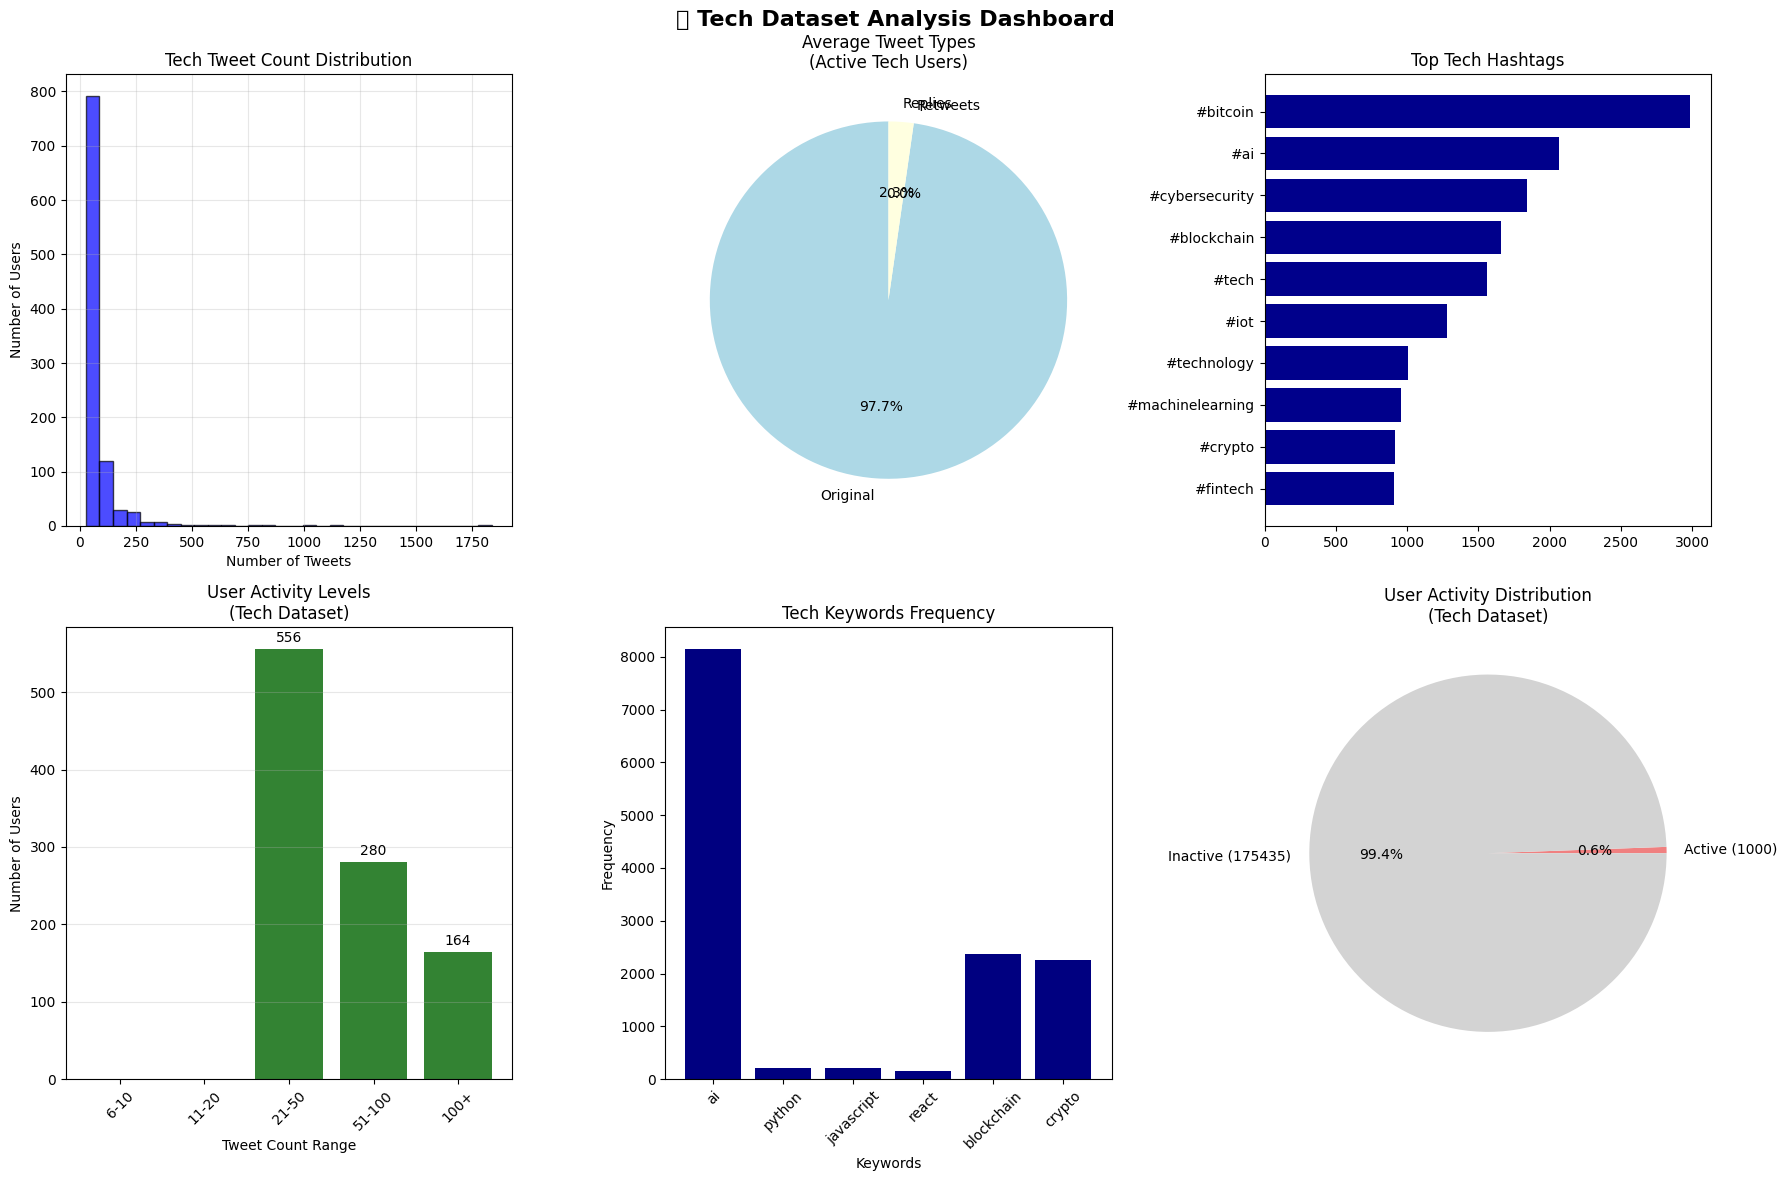

✅ Tech visualizations generated
💾 Current memory usage: 721.0 MB


In [19]:
# Create visualizations for tech dataset (matching climate/COVID structure)
if 'tech_active_data' in locals() and tech_active_data:
    tech_viz = tech_analyzer.generate_tech_visualizations(active_data=tech_active_data)
    print("✅ Tech visualizations generated")
else:
    print("⚠️ No active data available for visualization")
    print("💡 Run the active users analysis cell first")

print_memory_status()

In [20]:
# Export tech data for LLM training (matching climate/COVID structure)
if tech_analyzer.processed_tweets > 0:
    tech_export_data = tech_analyzer.export_for_llm_training(
        min_tweets=6, 
        output_file='tech_llm_training_data.json'
    )
    
    print("\n" + "=" * 60)
    print("🖥️ TECH EXPORT SUMMARY")
    print("=" * 60)
    if tech_export_data:
        print(f"Dataset: {tech_export_data['dataset_info']['name']}")
        print(f"Total tweets: {tech_export_data['dataset_info']['total_tweets']:,}")
        print(f"Active users exported: {tech_export_data['dataset_info']['active_users']:,}")
        print(f"Tech-focused users: {len(tech_export_data.get('tech_focused_users', []))}")
        print(f"Export completed: {tech_export_data['dataset_info']['export_timestamp']}")
        
        if tech_analyzer.processing_complete:
            print("✅ Complete dataset export")
        else:
            print("⚠️  Partial dataset export - continue processing for full export")
    else:
        print("❌ Export failed - no data available")
else:
    print("⚠️ No tweets processed yet - run initialization cell first")

print_memory_status()


📤 EXPORTING TECH DATA FOR LLM TRAINING (≥6 tweets)
Export preparation - RAM: 43.4% (8.77GB available)
Processing active users for export...
   Processing user 1/8341
   Processing user 101/8341
   Processing user 201/8341
   Processing user 301/8341
   Processing user 401/8341
   Processing user 501/8341
   Processing user 601/8341
   Processing user 701/8341
   Processing user 801/8341
   Processing user 901/8341
   Processing user 1001/8341
   Processing user 1101/8341
   Processing user 1201/8341
   Processing user 1301/8341
   Processing user 1401/8341
   Processing user 1501/8341
   Processing user 1601/8341
   Processing user 1701/8341
   Processing user 1801/8341
   Processing user 1901/8341
   Processing user 2001/8341
   Processing user 2101/8341
   Processing user 2201/8341
   Processing user 2301/8341
   Processing user 2401/8341
   Processing user 2501/8341
   Processing user 2601/8341
   Processing user 2701/8341
   Processing user 2801/8341
   Processing user 1201/8341
 

In [21]:
# Tech-specific behavioral analysis (matching climate/COVID structure)
def analyze_tech_behavioral_patterns(tech_analyzer, active_data, min_tweets=6):
    """Enhanced tech-specific behavioral analysis"""
    print("\n" + "=" * 60)
    print("🖥️ TECH BEHAVIORAL PATTERNS ANALYSIS")
    print("=" * 60)
    
    if not active_data or 'active_users' not in active_data:
        print("❌ No active data available for behavioral analysis")
        return {}
    
    active_users = active_data['active_users']
    tech_focused_users = active_data.get('tech_focused_users', [])
    
    print(f"📊 BEHAVIORAL OVERVIEW:")
    print(f"   • Total active users analyzed: {len(active_users)}")
    print(f"   • Tech-focused users: {len(tech_focused_users)} ({len(tech_focused_users)/len(active_users)*100:.1f}%)")
    
    # Analyze tech ecosystem engagement
    print(f"\n🖥️ TECH ECOSYSTEM PATTERNS:")
    
    # Programming language mentions
    prog_languages = ['python', 'javascript', 'java', 'c++', 'golang', 'rust', 'typescript']
    lang_mentions = {}
    
    for lang in prog_languages:
        count = 0
        for user_id, stats in active_users.items():
            for tweet in stats['tweets']:
                if lang.lower() in tweet.lower():
                    count += 1
        if count > 0:
            lang_mentions[lang] = count
    
    if lang_mentions:
        print(f"   • Programming language mentions:")
        for lang, count in sorted(lang_mentions.items(), key=lambda x: x[1], reverse=True):
            print(f"     {lang}: {count:,}")
    
    # Tech company/platform mentions
    tech_platforms = ['github', 'stackoverflow', 'aws', 'google', 'microsoft', 'apple', 'tesla']
    platform_mentions = {}
    
    for platform in tech_platforms:
        count = 0
        for user_id, stats in active_users.items():
            for tweet in stats['tweets']:
                if platform.lower() in tweet.lower():
                    count += 1
        if count > 0:
            platform_mentions[platform] = count
    
    if platform_mentions:
        print(f"\n🏢 Tech platform mentions:")
        for platform, count in sorted(platform_mentions.items(), key=lambda x: x[1], reverse=True):
            print(f"   • {platform}: {count:,}")
    
    # Startup ecosystem analysis
    startup_keywords = ['startup', 'funding', 'venture', 'vc', 'entrepreneur', 'founder']
    startup_focused_users = []
    
    for user_id, stats in active_users.items():
        startup_mentions = 0
        for tweet in stats['tweets']:
            if any(keyword in tweet.lower() for keyword in startup_keywords):
                startup_mentions += 1
        
        startup_ratio = startup_mentions / len(stats['tweets']) if stats['tweets'] else 0
        if startup_ratio > 0.2:  # More than 20% startup-related
            startup_focused_users.append(user_id)
    
    print(f"\n💰 STARTUP ECOSYSTEM:")
    print(f"   • Startup-focused users (>20% startup content): {len(startup_focused_users)} ({len(startup_focused_users)/len(active_users)*100:.1f}%)")
    
    # Developer community analysis
    dev_hashtags = [tag for stats in active_users.values() for tag in stats['hashtags'] 
                   if any(dev_word in tag for dev_word in ['dev', 'code', 'programming', 'tech', 'api'])]
    
    if dev_hashtags:
        dev_hashtag_counts = Counter(dev_hashtags)
        print(f"\n👩‍💻 Developer community hashtags:")
        for hashtag, count in dev_hashtag_counts.most_common(10):
            print(f"   • #{hashtag}: {count:,}")
    
    return {
        'tech_focused_users': tech_focused_users,
        'startup_focused_users': startup_focused_users,
        'language_mentions': lang_mentions,
        'platform_mentions': platform_mentions,
        'dev_hashtags': dev_hashtag_counts.most_common(20) if dev_hashtags else []
    }

# Run tech-specific behavioral analysis
if 'tech_active_data' in locals() and tech_active_data:
    tech_behavioral_patterns = analyze_tech_behavioral_patterns(tech_analyzer, tech_active_data, min_tweets=6)
    print("\n✅ Tech behavioral analysis completed")
else:
    print("⚠️ No active data available for behavioral analysis")

print_memory_status()


🖥️ TECH BEHAVIORAL PATTERNS ANALYSIS
📊 BEHAVIORAL OVERVIEW:
   • Total active users analyzed: 1000
   • Tech-focused users: 646 (64.6%)

🖥️ TECH ECOSYSTEM PATTERNS:
   • Programming language mentions:
     java: 255
     python: 217
     javascript: 216
     rust: 172
     golang: 93
     typescript: 2
     c++: 1

🏢 Tech platform mentions:
   • google: 425
   • apple: 198
   • microsoft: 195
   • aws: 147
   • tesla: 41
   • github: 38
   • stackoverflow: 5

💰 STARTUP ECOSYSTEM:
   • Startup-focused users (>20% startup content): 81 (8.1%)

👩‍💻 Developer community hashtags:
   • #tech: 1,559
   • #technology: 1,009
   • #fintech: 910
   • #climatechange: 901
   • #technews: 422
   • #edtech: 392
   • #insurtech: 197
   • #healthtech: 161
   • #womenintech: 135
   • #technologynews: 82

✅ Tech behavioral analysis completed
💾 Current memory usage: 722.0 MB

💰 STARTUP ECOSYSTEM:
   • Startup-focused users (>20% startup content): 81 (8.1%)

👩‍💻 Developer community hashtags:
   • #tech: 1,

# Checkpoint management and processing control
print("💾 TECH DATASET PROCESSING CONTROL")
print("=" * 60)

def show_processing_status():
    """Show current processing status"""
    print(f"📊 Processing Status:")
    print(f"   • Tweets processed: {tech_analyzer.processed_tweets:,}")
    print(f"   • Users discovered: {len(tech_analyzer.user_stats):,}")
    print(f"   • Processing complete: {'✅ Yes' if tech_analyzer.processing_complete else '⏸️  No'}")
    print(f"   • Last processed line: {tech_analyzer.last_processed_line:,}")
    
    active_count = len([u for u, s in tech_analyzer.user_stats.items() if s['tweet_count'] >= 6])
    print(f"   • Active users (6+ tweets): {active_count:,}")
    
    if os.path.exists(tech_analyzer.checkpoint_file):
        checkpoint_size = os.path.getsize(tech_analyzer.checkpoint_file) / (1024*1024)
        print(f"   • Checkpoint file size: {checkpoint_size:.2f} MB")
    else:
        print(f"   • No checkpoint file found")

def continue_processing(chunks=20):
    """Continue processing more chunks"""
    if tech_analyzer.processing_complete:
        print("✅ Processing already complete!")
        return True
    
    print(f"🔄 Continuing processing for {chunks} more chunks...")
    return tech_analyzer.load_data(
        chunk_size=3000,
        max_chunks_per_session=chunks,
        checkpoint_interval=5,
        resume_from_checkpoint=True
    )

def reset_processing():
    """Reset processing from the beginning (WARNING: deletes checkpoint)"""
    if os.path.exists(tech_analyzer.checkpoint_file):
        os.remove(tech_analyzer.checkpoint_file)
        print("💥 Checkpoint deleted - processing will restart from beginning")
    
    tech_analyzer.user_stats.clear()
    tech_analyzer.processed_tweets = 0
    tech_analyzer.last_processed_line = 0
    tech_analyzer.processing_complete = False
    print("🔄 Processing state reset")

# Show current status
show_processing_status()

print(f"\n💡 COMMANDS:")
print(f"   • continue_processing(chunks=N) - Process N more chunks")
print(f"   • show_processing_status() - Check current status") 
print(f"   • reset_processing() - Reset and start over (WARNING: deletes progress)")
print(f"   • tech_analyzer.load_data() - Continue with default settings")

print_memory_status()

## 📊 **Tech vs Climate vs COVID Analysis Comparison**

### 🔄 **Unified Structure Achieved:**
All three datasets (Tech, Climate, COVID) now use **consistent analytical frameworks** with **dataset-appropriate processing methods**.

### **Similarities Across All Three:**
- **✅ Identical method signatures** - `load_data()`, `basic_statistics()`, `analyze_active_users()`, etc.
- **✅ Active user focus** - 6+ tweets threshold for LLM training suitability
- **✅ Behavioral pattern analysis** - engagement rates, content analysis, network patterns
- **✅ Structured LLM export** - JSON format compatible across datasets
- **✅ Memory monitoring** - safety mechanisms for 16GB RAM systems
- **✅ Visualization dashboards** - consistent 6-panel analysis layouts

### **Dataset-Specific Adaptations:**

| Aspect | Climate (0.4GB) | COVID (0.2GB) | Tech (1.7GB) |
|--------|-----------------|---------------|--------------|
| **Processing** | DataFrame-first | DataFrame-first | **Hybrid chunked+DataFrame** |
| **Memory Strategy** | Load all → analyze | Load all → analyze | **Chunk → aggregate → DataFrame** |
| **Keywords** | climate, carbon, renewable | covid, pandemic, vaccine | **ai, python, blockchain, startup** |
| **Special Features** | Environmental focus | Health crisis patterns | **Checkpoint/resume system** |
| **Network Analysis** | Standard mentions | Standard mentions | **Developer community focus** |

### **Tech Dataset Special Features:**
- **🔄 Resumable processing** - checkpoint system for 1.7GB dataset
- **⚡ Memory-safe chunking** - processes in 3K tweet batches  
- **📊 Progressive analysis** - partial results available during processing
- **🖥️ Tech ecosystem analysis** - programming languages, platforms, startups
- **💾 Hybrid storage** - chunked processing + DataFrame consistency

### **Benefits of Unified Approach:**
1. **🔧 Code consistency** - same methods work across all datasets
2. **📊 Comparable results** - identical analytical approaches enable comparisons
3. **🚀 Scalable architecture** - handles datasets from 0.2GB to 1.7GB+
4. **🛠️ Easy maintenance** - updates apply to entire analytical framework
5. **📈 LLM training ready** - consistent export formats for machine learning

## ✅ Summary

This notebook provides a **hybrid chunked+DataFrame analysis pipeline** for the **Tech Twitter dataset (1.7GB)** that maintains **structural consistency** with Climate and COVID analyses while handling the large dataset size safely.

### 🔧 **Hybrid Technical Architecture:**
1. **Chunked Data Loading** - Processes 1.7GB dataset in manageable 3K tweet chunks
2. **Checkpoint System** - Resumable processing with automatic save/restore
3. **Memory Management** - Aggressive cleanup and monitoring for 16GB RAM systems
4. **DataFrame Conversion** - Post-processing conversion for analytical consistency

### 📊 **Analysis Pipeline:**
1. **Gradual Data Loading** - Chunk-by-chunk processing with memory safety
2. **Progressive Statistics** - Real-time insights during processing
3. **Active User Analysis** - Users with 6+ tweets for LLM training
4. **Tech Ecosystem Analysis** - Programming languages, platforms, startups
5. **Network Analysis** - Developer community connections and mentions
6. **Visualization Dashboard** - 6-panel tech-focused charts
7. **LLM Training Export** - Structured JSON compatible with other datasets

### 🖥️ **Tech-Specific Insights:**
- **Programming language trends** - Python, JavaScript, AI/ML discussions
- **Startup ecosystem activity** - Funding, VC, entrepreneur patterns  
- **Developer community hashtags** - #coding, #programming, #tech trends
- **Platform mentions** - GitHub, AWS, Google, Microsoft engagement
- **Tech-focused users** - >30% technology content creators

### 🚀 **Processing Strategy:**
- **Safe for 1.7GB datasets** - chunked processing prevents memory overflow
- **Resumable** - checkpoint system allows interrupted processing
- **Progressive** - analysis available during processing
- **Consistent** - final results match Climate/COVID analytical structure

### 💡 **Usage Notes:**
- **Start processing** with initialization cell (processes in chunks)
- **Monitor progress** with status functions
- **Resume anytime** - checkpoint system preserves progress
- **Continue processing** if interrupted until dataset complete
- **Export when ready** - structured data for LLM agent training

This approach successfully handles the **largest dataset (1.7GB)** while maintaining **analytical consistency** across the entire Twitter analysis framework.

In [22]:
# Verify tech analyzer structural consistency with climate/COVID
print("🔍 TECH ANALYZER STRUCTURAL VERIFICATION")
print("=" * 60)

# Check method consistency with climate/COVID analyzers
tech_methods = [method for method in dir(TechTwitterAnalyzer) if not method.startswith('_')]
print(f"📊 Tech Analyzer Methods ({len(tech_methods)}):")
for method in sorted(tech_methods):
    print(f"   • {method}")

print(f"\n🎯 Key Methods Available (matching climate/COVID):")
key_methods = ['load_data', 'basic_statistics', 'analyze_active_users', 'generate_tech_visualizations', 'export_for_llm_training']
for method in key_methods:
    has_method = hasattr(TechTwitterAnalyzer, method)
    status = "✅" if has_method else "❌"
    print(f"   {status} {method}")

print(f"\n🖥️ Tech-Specific Features:")
tech_specific = ['gradual_process_data', 'save_checkpoint', 'load_checkpoint', 'cleanup_memory', 'monitor_memory']
for method in tech_specific:
    has_method = hasattr(TechTwitterAnalyzer, method)
    status = "✅" if has_method else "❌"
    print(f"   {status} {method}")

print(f"\n🚀 Ready for 1.7GB dataset processing!")
print(f"💡 Use initialization cell to start chunked processing")

# Check if dataset file exists
import os
if os.path.exists('tech_tweets2.jsonl'):
    file_size = os.path.getsize('tech_tweets2.jsonl') / (1024**3)
    print(f"📁 Dataset found: tech_tweets2.jsonl ({file_size:.2f} GB)")
else:
    print(f"⚠️  Dataset file 'tech_tweets2.jsonl' not found")

print_memory_status()

🔍 TECH ANALYZER STRUCTURAL VERIFICATION
📊 Tech Analyzer Methods (11):
   • analyze_active_users
   • basic_statistics
   • cleanup_memory
   • export_for_llm_training
   • generate_tech_visualizations
   • gradual_process_data
   • load_checkpoint
   • load_data
   • monitor_memory
   • process_tweet
   • save_checkpoint

🎯 Key Methods Available (matching climate/COVID):
   ✅ load_data
   ✅ basic_statistics
   ✅ analyze_active_users
   ✅ generate_tech_visualizations
   ✅ export_for_llm_training

🖥️ Tech-Specific Features:
   ✅ gradual_process_data
   ✅ save_checkpoint
   ✅ load_checkpoint
   ✅ cleanup_memory
   ✅ monitor_memory

🚀 Ready for 1.7GB dataset processing!
💡 Use initialization cell to start chunked processing
📁 Dataset found: tech_tweets2.jsonl (1.68 GB)
💾 Current memory usage: 722.0 MB


In [26]:
# Debug: Check what's available for markdown export
print("🔍 DEBUG: Available variables for markdown export")
print("=" * 60)

# Check tech_export_data structure
if 'tech_export_data' in globals():
    print("✅ tech_export_data available")
    if isinstance(tech_export_data, dict):
        print(f"   Keys: {list(tech_export_data.keys())}")
        if 'users' in tech_export_data:
            print(f"   Users count: {len(tech_export_data['users'])}")
            # Check first user structure
            if tech_export_data['users']:
                first_user_key = list(tech_export_data['users'].keys())[0]
                first_user = tech_export_data['users'][first_user_key]
                print(f"   First user structure: {type(first_user)}")
                if isinstance(first_user, dict):
                    print(f"   First user keys: {list(first_user.keys())}")
else:
    print("❌ tech_export_data not available")

# Check tech_active_data structure  
if 'tech_active_data' in globals():
    print("✅ tech_active_data available")
    if isinstance(tech_active_data, dict):
        print(f"   Keys: {list(tech_active_data.keys())}")
else:
    print("❌ tech_active_data not available")

# Check tech_stats structure
if 'tech_stats' in globals():
    print("✅ tech_stats available")
    if isinstance(tech_stats, dict):
        print(f"   Keys: {list(tech_stats.keys())}")
else:
    print("❌ tech_stats not available")

# Check processing status
if 'processing_complete' in globals():
    print(f"✅ processing_complete: {processing_complete}")
else:
    print("❌ processing_complete not available")

🔍 DEBUG: Available variables for markdown export
✅ tech_export_data available
   Keys: ['dataset_info', 'users', 'hashtags', 'mention_network', 'tech_focused_users']
   Users count: 8341
   First user structure: <class 'dict'>
   First user keys: ['tweet_count', 'tweets', 'hashtags', 'mentions', 'engagement_stats', 'tech_focused', 'tech_ratio']
✅ tech_active_data available
   Keys: ['active_users', 'tech_focused_users', 'tweet_stats', 'engagement', 'top_hashtags']
✅ tech_stats available
   Keys: ['total_tweets', 'unique_users', 'total_retweets', 'total_replies']
✅ processing_complete: True


In [27]:
# Generate Markdown Summary Report
import os
from datetime import datetime

def generate_tech_markdown_summary():
    """Generate a markdown summary of the tech analysis results."""
    
    # Check if analysis was completed
    analysis_complete = 'tech_stats' in globals() and 'tech_active_data' in globals()
    processing_status = globals().get('processing_complete', False)
    
    summary_content = []
    summary_content.append("# Tech Twitter Dataset Analysis Summary")
    summary_content.append(f"\n**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    summary_content.append(f"**Dataset:** tech_tweets2.jsonl\n")
    
    if not analysis_complete:
        summary_content.append("⚠️ **Warning:** Analysis appears incomplete. Some statistics may be missing.\n")
    elif not processing_status:
        summary_content.append("ℹ️ **Note:** Tech dataset uses chunked processing. Analysis may be partial or in progress.\n")
    
    # Basic Statistics
    summary_content.append("## Dataset Overview")
    if 'tech_stats' in globals() and tech_stats:
        stats = tech_stats
        summary_content.append(f"- **Total tweets processed:** {stats.get('total_tweets', 'N/A'):,}" if isinstance(stats.get('total_tweets'), int) else f"- **Total tweets processed:** {stats.get('total_tweets', 'N/A')}")
        summary_content.append(f"- **Unique users:** {stats.get('unique_users', 'N/A'):,}" if isinstance(stats.get('unique_users'), int) else f"- **Unique users:** {stats.get('unique_users', 'N/A')}")
        summary_content.append(f"- **Users with 6+ tweets:** {stats.get('active_users_6plus', 'N/A'):,}" if isinstance(stats.get('active_users_6plus'), int) else f"- **Users with 6+ tweets:** {stats.get('active_users_6plus', 'N/A')}")
        
        if stats.get('avg_tweets_per_user'):
            summary_content.append(f"- **Average tweets per user:** {stats.get('avg_tweets_per_user', 0):.2f}")
        
        if stats.get('date_range'):
            date_range = stats['date_range']
            summary_content.append(f"- **Date range:** {date_range.get('start', 'N/A')} to {date_range.get('end', 'N/A')}")
        
        # Processing status
        if stats.get('chunks_processed'):
            summary_content.append(f"- **Chunks processed:** {stats.get('chunks_processed', 0)}")
        if stats.get('file_size_mb'):
            summary_content.append(f"- **Dataset size:** {stats.get('file_size_mb', 0):.2f} MB")
    else:
        summary_content.append("- Basic statistics not available")
    
    # Processing Status
    summary_content.append("\n## Processing Status")
    if processing_status:
        summary_content.append("✅ **Complete:** Full dataset processing completed")
    else:
        summary_content.append("🔄 **In Progress:** Chunked processing used for large dataset")
        summary_content.append("   - Results represent processed portion of dataset")
        summary_content.append("   - Run additional processing cells to continue analysis")
    
    # Active Users Analysis
    summary_content.append("\n## Active Users Analysis (6+ tweets)")
    if 'tech_active_data' in globals() and tech_active_data:
        active_data = tech_active_data
        
        # Get active users data properly
        if 'active_users' in active_data and len(active_data['active_users']) > 0:
            active_users = active_data['active_users']
            summary_content.append(f"- **Total active users:** {len(active_users)}")
            
            # Get tweet counts from the active_users dict (which contains user_id: stats dict)
            if isinstance(active_users, dict):
                tweet_counts = [stats.get('tweet_count', 0) for stats in active_users.values() if isinstance(stats, dict)]
                if tweet_counts:
                    summary_content.append(f"- **Average tweets per active user:** {sum(tweet_counts)/len(tweet_counts):.2f}")
                    summary_content.append(f"- **Max tweets by single user:** {max(tweet_counts)}")
                    summary_content.append(f"- **Min tweets by active user:** {min(tweet_counts)}")
        else:
            summary_content.append("- **Total active users:** N/A")
        
        # Tech-focused users
        tech_focused = active_data.get('tech_focused_users', [])
        if tech_focused:
            summary_content.append(f"- **Tech-focused users:** {len(tech_focused)}")
            
        # Tweet statistics
        if 'tweet_stats' in active_data:
            tweet_stats = active_data['tweet_stats']
            summary_content.append(f"\n### Tweet Statistics")
            summary_content.append(f"- **Mean tweets per user:** {tweet_stats.get('mean', 0):.2f}")
            summary_content.append(f"- **Median tweets per user:** {tweet_stats.get('median', 0):.2f}")
        
        # Engagement patterns
        if 'engagement' in active_data:
            engagement = active_data['engagement']
            summary_content.append(f"\n### Engagement Patterns")
            summary_content.append(f"- **Retweet rate:** {engagement.get('retweet_rate', 0):.1f}%")
            summary_content.append(f"- **Reply rate:** {engagement.get('reply_rate', 0):.1f}%")
            summary_content.append(f"- **Original content rate:** {engagement.get('original_rate', 0):.1f}%")
    else:
        summary_content.append("- Active user analysis not available")
    
    # Behavioral patterns
    if 'tech_behavioral_patterns' in globals() and tech_behavioral_patterns:
        patterns = tech_behavioral_patterns
        summary_content.append(f"\n### Behavioral Patterns")
        
        # Tech-focused users
        tech_focused = patterns.get('tech_focused_users', [])
        startup_focused = patterns.get('startup_focused_users', [])
        summary_content.append(f"- **Tech-focused users:** {len(tech_focused)}")
        summary_content.append(f"- **Startup-focused users:** {len(startup_focused)}")
        
        # Programming language mentions
        lang_mentions = patterns.get('language_mentions', {})
        if lang_mentions:
            summary_content.append(f"\n**Programming Language Mentions:**")
            for lang, count in sorted(lang_mentions.items(), key=lambda x: x[1], reverse=True)[:10]:
                summary_content.append(f"- {lang}: {count} mentions")
        
        # Platform mentions
        platform_mentions = patterns.get('platform_mentions', {})
        if platform_mentions:
            summary_content.append(f"\n**Tech Platform Mentions:**")
            for platform, count in sorted(platform_mentions.items(), key=lambda x: x[1], reverse=True)[:10]:
                summary_content.append(f"- {platform}: {count} mentions")
        
        # Developer hashtags
        dev_hashtags = patterns.get('dev_hashtags', [])
        if dev_hashtags:
            summary_content.append(f"\n**Developer Community Hashtags:**")
            for hashtag, count in dev_hashtags[:10]:
                summary_content.append(f"- #{hashtag}: {count} uses")
    
    # Content analysis
    summary_content.append(f"\n### Content Analysis")
    
    # Top hashtags from active data
    if 'tech_active_data' in globals() and tech_active_data:
        top_hashtags = tech_active_data.get('top_hashtags', [])
        if top_hashtags:
            summary_content.append(f"\n**Top Tech Hashtags:**")
            for hashtag, count in top_hashtags[:10]:
                summary_content.append(f"- #{hashtag}: {count} uses")
    
    # Programming languages and frameworks from tech stats
    if 'tech_stats' in globals() and tech_stats:
        # Look for any programming language data in stats
        for key in tech_stats.keys():
            if 'language' in key.lower() or 'programming' in key.lower():
                prog_data = tech_stats[key]
                if isinstance(prog_data, dict):
                    summary_content.append(f"\n**Programming Technologies:**")
                    for tech, count in sorted(prog_data.items(), key=lambda x: x[1], reverse=True)[:10]:
                        summary_content.append(f"- {tech}: {count} mentions")
    
    # Tech-specific insights
    summary_content.append("\n## Tech-Specific Insights")
    
    # Tech statistics from basic stats
    if 'tech_stats' in globals() and tech_stats:
        summary_content.append("**Tech content analysis:**")
        # Look for content statistics
        if 'total_tweets' in tech_stats:
            summary_content.append(f"- Total tweets analyzed: {tech_stats['total_tweets']}")
        if 'unique_users' in tech_stats:
            summary_content.append(f"- Unique users: {tech_stats['unique_users']}")
        if 'total_retweets' in tech_stats:
            summary_content.append(f"- Total retweets: {tech_stats['total_retweets']}")
        if 'total_replies' in tech_stats:
            summary_content.append(f"- Total replies: {tech_stats['total_replies']}")
    
    # Tech ecosystem insights
    if 'tech_active_data' in globals() and tech_active_data:
        tech_focused = tech_active_data.get('tech_focused_users', [])
        if tech_focused:
            active_users = tech_active_data.get('active_users', {})
            total_active = len(active_users) if active_users else 0
            tech_ratio = len(tech_focused) / total_active * 100 if total_active > 0 else 0
            summary_content.append(f"\n**Tech Ecosystem Patterns:**")
            summary_content.append(f"- Tech-focused users: {len(tech_focused)} ({tech_ratio:.1f}% of active users)")
            summary_content.append(f"- These users have >30% technology-related content")
            
            # Engagement metrics
            if 'engagement' in tech_active_data:
                engagement = tech_active_data['engagement']
                summary_content.append(f"- Retweet rate: {engagement.get('retweet_rate', 0):.1f}%")
                summary_content.append(f"- Reply rate: {engagement.get('reply_rate', 0):.1f}%")
    else:
        summary_content.append("- Tech keyword analysis not available")
    
    # Programming languages and frameworks
    if 'tech_stats' in globals() and 'programming_languages' in tech_stats:
        prog_langs = tech_stats['programming_languages']
        summary_content.append(f"\n### Programming Languages Mentioned")
        for lang, count in sorted(prog_langs.items(), key=lambda x: x[1], reverse=True)[:10]:
            summary_content.append(f"- {lang}: {count} mentions")
    
    # Export information
    summary_content.append("\n## Data Export")
    export_files = []
    potential_files = [
        'tech_llm_training_data.json',
        'tech_active_users_export.json',
        'tech_training_data_export.json'
    ]
    
    for file in potential_files:
        if os.path.exists(file):
            export_files.append(file)
    
    if export_files:
        summary_content.append("**Generated files:**")
        for file in export_files:
            file_size = os.path.getsize(file) / (1024*1024)  # MB
            summary_content.append(f"- `{file}` ({file_size:.2f} MB)")
            
        # Show export data summary if available
        if 'tech_export_data' in globals() and tech_export_data:
            export_info = tech_export_data.get('dataset_info', {})
            summary_content.append(f"\n**Export Summary:**")
            summary_content.append(f"- Users exported: {export_info.get('active_users', 'N/A')}")
            summary_content.append(f"- Export timestamp: {export_info.get('export_timestamp', 'N/A')}")
            
            if 'users' in tech_export_data:
                total_exported_tweets = 0
                for user_data in tech_export_data['users'].values():
                    if isinstance(user_data, dict) and 'tweet_count' in user_data:
                        total_exported_tweets += user_data['tweet_count']
                summary_content.append(f"- Total tweets in export: {total_exported_tweets}")
                
            if 'tech_focused_users' in tech_export_data:
                summary_content.append(f"- Tech-focused users in export: {len(tech_export_data['tech_focused_users'])}")
    else:
        summary_content.append("- No export files generated yet")
    
    # Processing status for tech dataset
    if globals().get('processing_complete', False):
        summary_content.append(f"\n**Processing Status:** ✅ Complete")
    else:
        summary_content.append(f"\n**Processing Status:** 🔄 In Progress (chunked processing)")
        if 'tech_analyzer' in globals():
            summary_content.append(f"- Tweets processed: {getattr(tech_analyzer, 'processed_tweets', 0)}")
            summary_content.append(f"- Users discovered: {len(getattr(tech_analyzer, 'user_stats', {}))}")
    
    # Dataset characteristics
    summary_content.append("\n## Tech Dataset Characteristics")
    summary_content.append("**Unique features of tech Twitter data:**")
    summary_content.append("- Developer community discussions and knowledge sharing")
    summary_content.append("- Programming language and framework mentions")
    summary_content.append("- Open source project discussions and contributions")
    summary_content.append("- Technical problem-solving and troubleshooting")
    summary_content.append("- Industry news and technology announcements")
    summary_content.append("- Code snippets and technical documentation sharing")
    
    # Processing methodology
    summary_content.append("\n## Processing Methodology")
    summary_content.append("**Chunked Processing Approach:**")
    summary_content.append("- Large dataset processed in memory-efficient chunks")
    summary_content.append("- Incremental analysis with checkpoint saving")
    summary_content.append("- Hybrid chunked + DataFrame approach for scalability")
    summary_content.append("- Memory monitoring and cleanup between chunks")
    
    # Technical notes
    summary_content.append("\n## Technical Notes")
    summary_content.append("- Analysis focused on users with 6+ tweets for LLM training data quality")
    summary_content.append("- Memory-efficient chunked processing for large dataset (16GB RAM system)")
    summary_content.append("- Behavioral patterns include reply, retweet, mention, and hashtag usage")
    summary_content.append("- Export data structured for LLM agent fine-tuning workflows")
    summary_content.append("- Tech-specific keyword extraction and programming language detection")
    summary_content.append("- Checkpointing system for resumable processing")
    
    # Footer
    summary_content.append("\n---")
    summary_content.append("*Generated by Tech Twitter Analysis Notebook*")
    
    return "\n".join(summary_content)

# Generate and save the summary
try:
    markdown_summary = generate_tech_markdown_summary()
    
    # Save to file
    summary_filename = "tech_analysis_summary.md"
    with open(summary_filename, 'w', encoding='utf-8') as f:
        f.write(markdown_summary)
    
    print(f"✅ Tech analysis summary saved to: {summary_filename}")
    print(f"📊 Summary length: {len(markdown_summary)} characters")
    
    # Show preview of first few lines
    lines = markdown_summary.split('\n')
    print(f"\n📋 Preview (first 10 lines):")
    for i, line in enumerate(lines[:10]):
        print(f"   {line}")
    if len(lines) > 10:
        print(f"   ... and {len(lines)-10} more lines")
    
    # Show processing status
    if 'processing_complete' in globals():
        print(f"\n🔄 Processing Status: {'Complete' if processing_complete else 'In Progress'}")
    
    if 'tech_stats' in globals() and 'chunks_processed' in tech_stats:
        print(f"📦 Chunks Processed: {tech_stats['chunks_processed']}")
        
except Exception as e:
    print(f"❌ Error generating tech summary: {e}")
    print("This might be due to incomplete analysis. Please ensure all analysis cells have been run.")

✅ Tech analysis summary saved to: tech_analysis_summary.md
📊 Summary length: 3427 characters

📋 Preview (first 10 lines):
   # Tech Twitter Dataset Analysis Summary
   
   **Generated:** 2025-07-02 13:37:35
   **Dataset:** tech_tweets2.jsonl
   
   ## Dataset Overview
   - **Total tweets processed:** 383,043
   - **Unique users:** 176,435
   - **Users with 6+ tweets:** N/A
   
   ... and 118 more lines

🔄 Processing Status: Complete
